## *Capstone Project One*: Iceberg or ship classification, [kaggle Statoil/C-CORE Iceberg Classifier Challenge](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)

January 2018

## Abstract

toc

## 1 Introduction

In the movie Titanic, the drifting icebergs were monitored by human eye, which is inefficient and not reliable. Nowadays, people use satellite data for the detecting drifting icebergs. This is especially important for the safety of ships or oil stations in a harsh environment.

The satellite radar works as bouncing a signal off an object and receive the backscattering signal from the object. The received signal is translated into an image. And through that image we can apply classifiers to detect if there are threaten icebergs in that image area. 

There are several factors to be consider: first, the radar signal contains H and V parts. During the backscattering on an object, the H and V parts will change differently due to the physical propeties of the object. Thus, the change of the two parts contains important information [[1]](http://www.nrcan.gc.ca/node/9567). In this kaggle challenge, dual-polarization image was give with two channels: HH (horizonal transmit and horizontal receive) and HV (horizonal transmit and vertical receive). Second, the image is affected by the weather conditions such as the speed of the wind. High wind will generate a brighter background and low wind will generate a darker background. Third is the incidence angle the radar transmit and receive data. The ocean background will be darker at a higher incident angle.

Client of the project would be remote sensing companies like [C-CORE](https://www.c-core.ca/).

## 2 Analysis
### 2.1 data import
There are two data file available from this kaggle challenge: train.json (196.3 MB) and test.json (1.52 GB). The test.json contains data without labels. The predicted label from a team will be evaluated in the public Leaderboard which contains 20% of the test data. All the predicted label will be evaluated after the deadline of the challenge (January 23, 2018)


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#Load the data.
train_pd = pd.read_json("train.json")
test_pd = pd.read_json("test.json")

### 2.2 data exploration
We can overview the data using: 

[1] train_pd.tail()

here is the output:
![tail](img/tail.png)
[2] test_pd.tail()

here is the output:
![tail_test](img/tail_test.png)

#### This training dataset is good balanced, 53.05% are ship/not iceberg.

In [3]:
print("iceberg percentage in training sample: %.2f%%" % sum(train_pd['is_iceberg']/len(train_pd)*100))

iceberg percentage in training sample: 46.95%


### 2.3 Rearrange the data as 75x75 image data

In [4]:
#process the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train_pd["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train_pd["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

#process the testing data
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test_pd["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test_pd["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis],((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)


### 2.4 Deal with the missing data in 'inc_angle'

In [6]:
#replace 'na' with the average of the inc_angle
i=0
ls=[]
angle=np.array(train_pd['inc_angle'])
for a in angle:
    if a == 'na':
        i = i+1
    else:
        ls.append(a)
        
#calculate the average angle with the available data
ave=sum(ls)/(len(angle)-i)

#asign the 'na' data with the average value and convert to float32
angle[angle=='na']=ave
angle = angle.astype(np.float32)
angle

array([ 43.9239006 ,  38.15620041,  45.28590012, ...,  39.26870728,
        39.26870728,  39.26870728], dtype=float32)

### 2.5 Save file in .npy formate

In [7]:
target_train = train_pd['is_iceberg']
test_id = test_pd['id']

np.save("X_train.npy",X_train)
np.save("X_test.npy",X_test)
np.save("angle.npy",angle)
np.save("target_train.npy",target_train)
np.save("test_id.npy",test_id)

#### For future convinience (faster reading speed, and upload in aws), the .json was converted and saved as .npy file by pd.read_json() and np.save().

output files: 
1. X_train.npy
2. X_test.npy
3. angle.npy
4. test_id.npy
5. target_train.npy

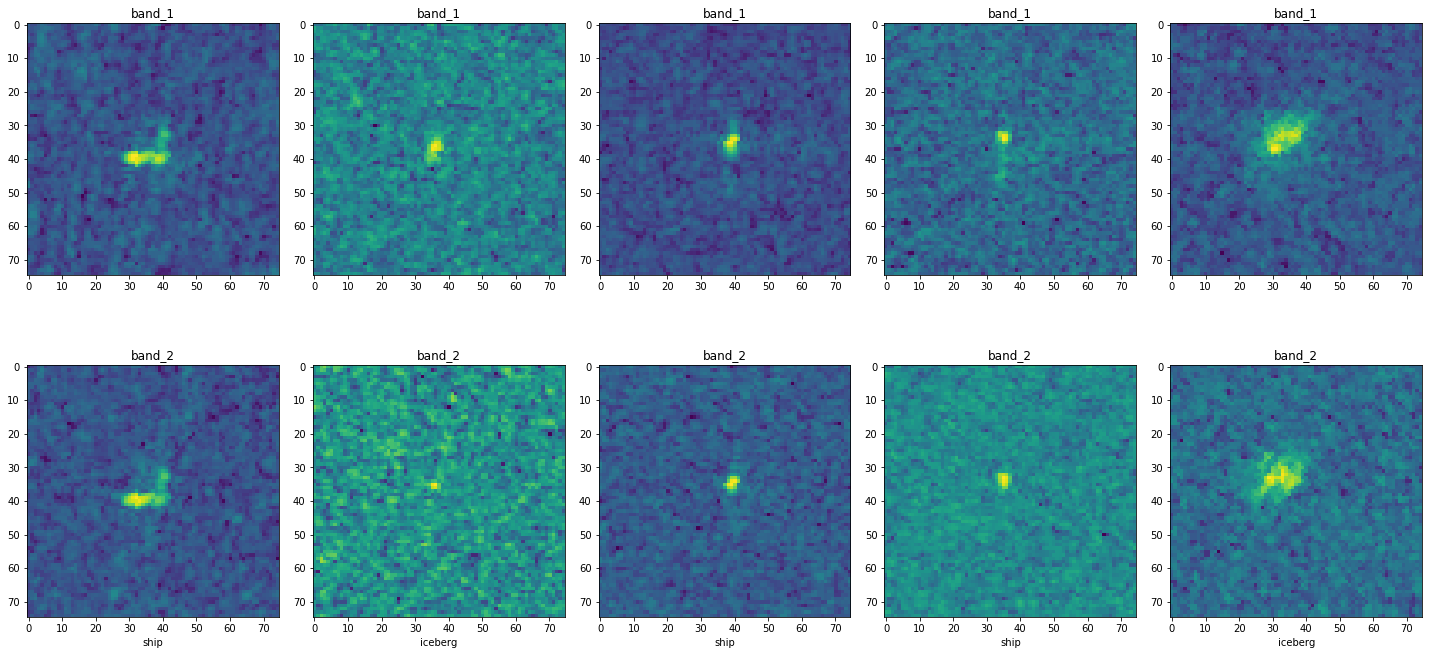

In [8]:
plt.figure(figsize=(20,10))
for example in range(1,6):
   
    plt.subplot(2,5,example)
    plt.imshow(X_band_1[example])
    plt.title('band_1')

    plt.subplot(2,5,5+example)
    plt.imshow(X_band_2[example])
    plt.title('band_2')
    if train_pd['is_iceberg'][example] == 1:
        plt.xlabel('iceberg')
    else:
        plt.xlabel('ship')

plt.tight_layout()

### 2.3 Image argumentation
#### rotate the images 90 degrees and 180 degrees respectively (to increase the amount of training data)
Data argumentation is important when we only have a limit number of training samples and complex model which tends to overfit. Image argumentation is used to generate more images for training purpose. For example, we can rotate the image at certain angle and it still represent the same sample, but the model may be able to learn some new features from the image. Keras have a build-in function for image argumentation: [ImageDataGenerator](https://keras.io/preprocessing/image/). In this section, we shows an example of manually rotate the image to rotate the image 90 degree and 180 degree.

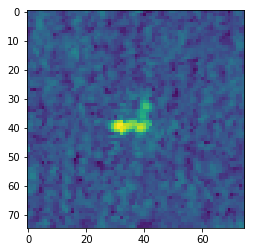

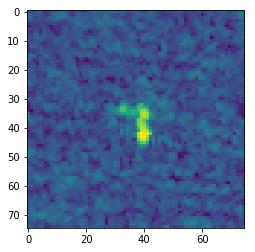

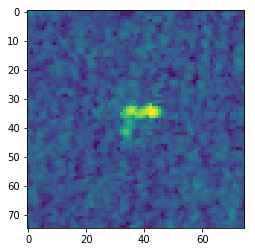

In [9]:
plt.imshow(X_band_1[1])

X_band_1_rotate90 = np.array([np.rot90(image) for image in X_band_1])
X_band_2_rotate90 = np.array([np.rot90(image) for image in X_band_2])
plt.figure()
plt.imshow(X_band_1_rotate90[1])

X_band_1_rotate180 = np.array([np.rot90(image,2) for image in X_band_1])
X_band_2_rotate180 = np.array([np.rot90(image,2) for image in X_band_2])
plt.figure()
plt.imshow(X_band_1_rotate180[1])

## 3 Image classification Models
In this chapter, we will apply and compare two very popular classification algorithm for image classification: random forest and convolutional neural network.
### 3.1 Random forest
The reason we choose random forest is that it usually shows a superior performance over other algorithms such as logistic regression and SVM. And it is fast and it utilize "bagging" to enable the power of random. Although it's not the best algorithm known for image classification, it's worthwhile to learn and test the performance of it. We use scikit-learn to implement [random forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Learning resources:

1. [Chapter 5: Classification of land cover, Chris Holden](http://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html)



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X_train, target_train)

### 3.2 Covnet
Image classification or object recognition is a simple and nature thing to human beings, but it's not so easy for computers. The same object may look quite different in two photos and it's hard for computer algorithms to learn that. However, since 2010, this field has made tremendous progress using Convolutional neural networks (Convnet), and also thanks to the improvement of the computational speed and some large image database like [ImageNet](http://www.image-net.org/). 

We will use neural network library [Keras](https://keras.io/) in this section.

Learning resources:
1. [Stanford U. cs231n](http://cs231n.stanford.edu/)

Reference resources for the models:
1. [Keras Model for Beginners (0.210 on LB)+EDA+R&D by DeveshMaheshwari](https://www.kaggle.com/devm2024/keras-model-for-beginners-0-210-on-lb-eda-r-d)
2.  [Welcome to deep learning (CNN 99%) by Peter Grenholm](https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99)
3.  [Display Deep Learning Model Training History in Keras by Jason Brownlee](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)
4. [Evaluate the Performance Of Deep Learning Models in Keras by Jason Brownlee](https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/)

#### load data

In [ ]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
test_id = np.load('test_id.npy')
angle = np.load('angle.npy')
target_train = np.load('target_train.npy')

#### Build the model

In [ ]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, BatchNormalization
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 2)))
    gmodel.add(BatchNormalization())
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))
    
    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

file_path = "model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

#### Train the model

In [ ]:
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.9)

import os
gmodel=getModel()
history = gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=30,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

In [ ]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#### plot the training process

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Predict new data
After training the Convnet, we can use it to predict new images. I put the result in kaggle and the best score I get from this model is 0.20 (log loss).

In [ ]:
predicted_test=gmodel.predict_proba(X_test)
submission = pd.DataFrame()
submission['id']=test_id
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)

### 3.3 Transfer learning: VGG16
Training a new Convnet can be time_consuming, and there are a lot of hyperparameters to be decided as well as the architecture of it. We then moved forward to transfer learning, which means we use the some already trained Convnet and adjust it to solve this problem. Because those pre-trained covnet contains features captures which maybe useful in this problem. VGG16 is a well known pre-trained convnet which won 2014 ImageNet challenge.

Learning resource:
1. [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import optimizers
from keras.optimizers import Adam
from keras.applications.vgg19 import VGG19

In [ ]:
img_width, img_height = 150, 150
epochs = 50
batch_size = 16
split = 0.9

In [ ]:
def get_callbacks(filepath, patience):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

def train_top_model(input_shape):
    
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=adam,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    #model.summary()
    return model
file_path = 'top_model_weights_path.h5'

#### get bottleneck features

In [ ]:
import os 
model = applications.VGG16(include_top=False, weights='imagenet')


X_train = model.predict(X_train_rotate)
input_shape=X_train.shape[1:]

#### train the model, cv

In [ ]:
#fold cross validation
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=8, shuffle=False, random_state=seed)

cvscores = []
model = train_top_model(input_shape)
for train, test in kfold.split(X_train, target_train):
    model = train_top_model(input_shape)
    model.fit(X_train[train], target_train[train],
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0,
                    validation_data=(X_train[test], target_train[test]),
                    callbacks=get_callbacks(file_path, patience=5))
    model.load_weights(filepath=file_path)
    scores = model.evaluate(X_train[test], target_train[test], verbose=0)
    print(model.metrics_names[0], scores[0])
    cvscores.append(scores[0])
print('Test loss average:',np.mean(cvscores), 'Test loss std:',np.std(cvscores))

#### predict new image

In [ ]:
predicted_test=model.predict(X_test,verbose=1)
submission = pd.DataFrame()
test_id=np.load('test_id.npy')
submission['id']=test_id
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)

### 3.4 Transfer learning: VGG16 with fine tuning the last covnet layer

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.optimizers import Adam
from keras.applications.vgg19 import VGG19

In [ ]:
weights_path = 'vgg16_weights.h5'
top_model_weights_path = 'top_model_weights_path.h5'

In [ ]:
epochs = 10
batch_size = 24
split=0.9

In [ ]:
def get_callbacks(filepath, patience):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def model_plus():
    base_model = applications.VGG16(weights='imagenet', include_top=False,input_shape=(75,75,3))
    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(512, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
  
    top_model.load_weights(top_model_weights_path)
 
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
  
    for layer in model.layers[:-5]:
        layer.trainable = False
  
    mypotim=Adam(lr=0.00001, beta_1=0.5, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    return model

file_path = "model_weights.hdf5"

### train the model and cv

In [ ]:
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=seed)
cvscores = []
cvscores_ = []
for train, test in kfold.split(X_train, target_train):
    model = model_plus()
    model.fit(X_train[train], target_train[train],
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0,
                    validation_data=(X_train[test], target_train[test]),
                    callbacks = get_callbacks(file_path,5))
    model.load_weights(filepath=file_path)
    scores = model.evaluate(X_train[test], target_train[test], verbose=0)
    print(model.metrics_names[0], scores[0])
    print(model.metrics_names[1], scores[1])
    cvscores.append(scores[0])
    cvscores_.append(scores[1])
print('Test loss average:',np.mean(cvscores), 'Test loss std:',np.std(cvscores))
print('Test acc average:',np.mean(cvscores_), 'Test loss std:',np.std(cvscores_))